<a href="https://colab.research.google.com/github/iNuman/PytorchDeepLearnignPlayGround/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-sl2ig636
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-sl2ig636
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


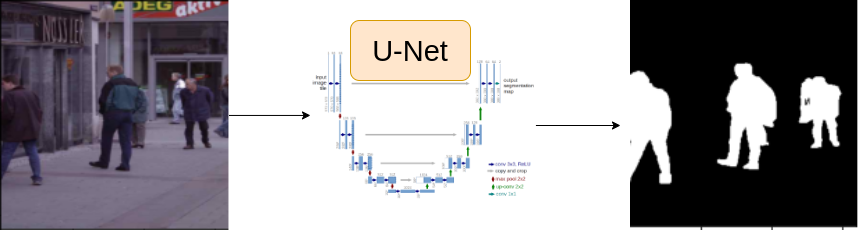

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/content/"

DEVICE = "cuda"
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16
ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

print(f"Image Shape : {image.shape}")
print(f"Mask Shape : {mask.shape}")


Image Shape : (183, 276, 3)
Mask Shape : (183, 276)


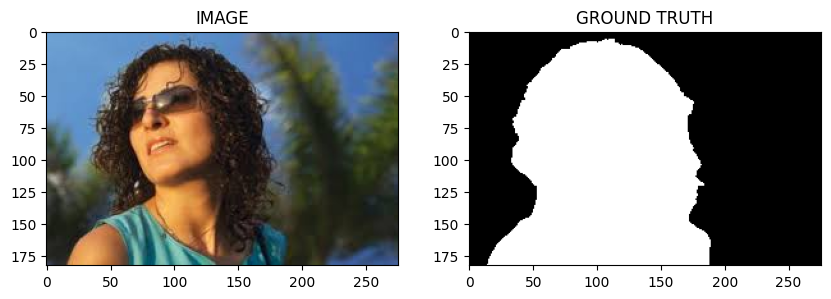

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data["image"]
      mask = data["mask"]

    # We will shift the shape from h, w, c to c, h, w as pytorch works on this
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    # Now converting from numpy to tensor
    # Dividing them with 255.0 to convert them to 0 and 1
    image = torch.tensor(image, dtype=torch.float) / 255.0
    mask = torch.round(torch.tensor(mask, dtype=torch.float)) / 255.0

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


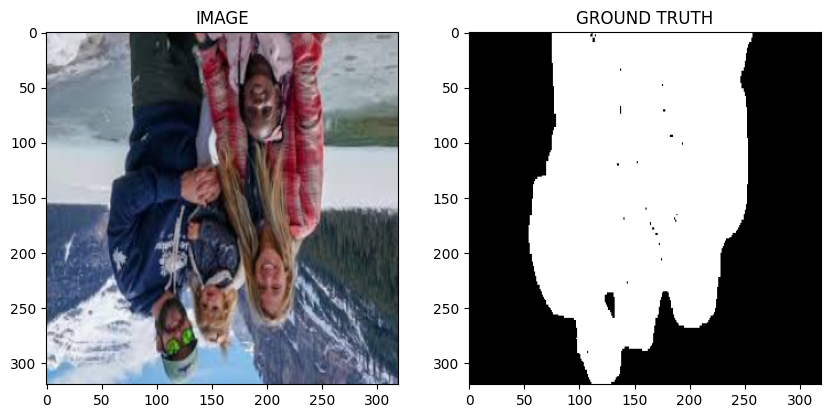

In [ ]:
idx = 2

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
    break

print(f"One batch Image shape : {image.shape}")
print(f"One batch Mask shape : {mask.shape}")

One batch Image shape : torch.Size([16, 3, 320, 320])
One batch Mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
      #  logits mean raw outputs without any activation function
        logits = self.arc(images)
        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            #  BCE means binary cross entropy with logit loss
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        return logits

In [ ]:
model = SegmentationModel()
# Move the model to cuda - GPU
model = model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):

    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader) # avg loss


In [ ]:
def valid_fn(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
      for images, masks in tqdm(data_loader):
          images = images.to(DEVICE)
          masks = masks.to(DEVICE)

          logits, loss = model(images, masks)

          total_loss += loss.item()

    return total_loss / len(data_loader) # avg loss


# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.inf

for epoch in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = valid_fn(validloader, model)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved Best Model!")

    print(f"Epoch : {epoch+1} Train_loss : {train_loss} Valid loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Saved Best Model!
Epoch : 1 Train_loss : 0.8562021017074585 Valid loss : 5.2211931347846985


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Saved Best Model!
Epoch : 2 Train_loss : 0.37705059846242267 Valid loss : 0.3552268035709858


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch : 3 Train_loss : 0.3647674004236857 Valid loss : 0.38122236728668213


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Saved Best Model!
Epoch : 4 Train_loss : 0.29078009525934856 Valid loss : 0.2582307383418083


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Saved Best Model!
Epoch : 5 Train_loss : 0.24830326040585834 Valid loss : 0.22625869512557983


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Epoch : 6 Train_loss : 0.25022552311420443 Valid loss : 0.32380639016628265


100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


Saved Best Model!
Epoch : 7 Train_loss : 0.2023989568154017 Valid loss : 0.2185257337987423


100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Saved Best Model!
Epoch : 8 Train_loss : 0.1685481573144595 Valid loss : 0.18814290687441826


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Epoch : 9 Train_loss : 0.1740986963113149 Valid loss : 0.2042943350970745


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch : 10 Train_loss : 0.16971596678098042 Valid loss : 0.21386844292283058


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch : 11 Train_loss : 0.16725797057151795 Valid loss : 0.23130915313959122


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Epoch : 12 Train_loss : 0.1764499381184578 Valid loss : 0.19318991899490356


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


Epoch : 13 Train_loss : 0.15451620817184447 Valid loss : 0.29264386743307114


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Saved Best Model!
Epoch : 14 Train_loss : 0.17162184069554012 Valid loss : 0.1779608465731144


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Saved Best Model!
Epoch : 15 Train_loss : 0.13693536619345348 Valid loss : 0.1720411777496338


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch : 16 Train_loss : 0.12793508370717366 Valid loss : 0.19415079802274704


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch : 17 Train_loss : 0.10542926490306855 Valid loss : 0.20183748379349709


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Saved Best Model!
Epoch : 18 Train_loss : 0.12369388788938522 Valid loss : 0.1614673249423504


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch : 19 Train_loss : 0.11336944003899892 Valid loss : 0.21957848221063614


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch : 20 Train_loss : 0.11720755845308303 Valid loss : 0.18291449546813965


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch : 21 Train_loss : 0.1866234873731931 Valid loss : 0.24563422426581383


100%|██████████| 4/4 [00:00<00:00,  6.23it/s]


Epoch : 22 Train_loss : 0.1756870299577713 Valid loss : 0.2849132940173149


100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


Epoch : 23 Train_loss : 0.13720204283793766 Valid loss : 0.2468607760965824


100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


Epoch : 24 Train_loss : 0.13694614271322886 Valid loss : 0.1885341927409172


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

Epoch : 25 Train_loss : 0.1086023693283399 Valid loss : 0.20047221891582012


# Task 9 : Inference

In [ ]:
idx = 2

model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
# logits_mask = logits_mask.cpu().squeeze(0)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

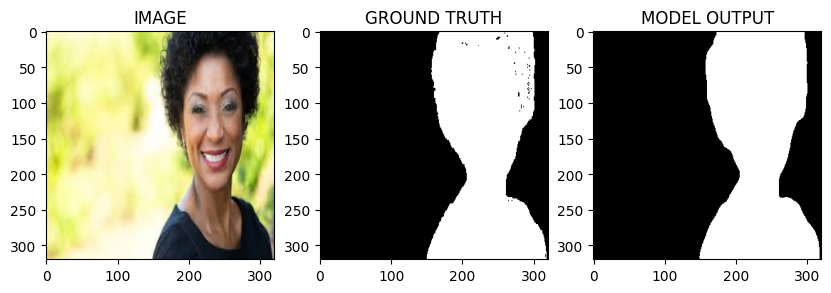

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya